In [1]:
# !pip install --quiet --pre dgl-cu101
# !pip install --quiet catboost==0.25.1
# !pip install --quiet category-encoders==2.2.2
# !pip install --quiet torch==1.6.0
# !pip install --quiet scikit-learn==0.24.2

In [2]:
import argparse
import itertools
import time
import pickle
import random
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

from collections import defaultdict as ddict
import pandas as pd
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
import json
import os

from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

import catboost
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, sum_models
import category_encoders
from category_encoders import CatBoostEncoder

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
# import tsne_func

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import dgl
import dgl.nn as dglnn
import dgl.function as Fn

data_dir="/home/ubuntu/"
root_dir="/mnt/bgnn/multi-classification"

os.chdir(root_dir)

print(catboost.__version__)
print(category_encoders.__version__)
print(torch.__version__)

Using backend: pytorch


0.25.1
2.2.2
1.6.0


In [3]:
def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [4]:
KG_dir="/home/ubuntu/"

if os.path.isfile("/home/ubuntu/CAP_Graph_07082021")==False:
    !hdfs dfs -get /dz/dz_6104/disc.db/CAP_Graph_07082021  ~/CAP_Graph_07082021

start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph_07082021'), 'rb') as f:
    hg,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label= pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))


It took 7.4383 seconds to load graph


In [5]:
KG_dir="/home/ubuntu/"

if os.path.isfile("/home/ubuntu/vertices_reindex_pickle")==False:
    !hdfs dfs -get /dz/dz_6104/disc.db/vertices_reindex_pickle  ~/vertices_reindex_pickle

vertices=utils.read_pickle(KG_dir,'vertices_reindex_pickle')
vertices.head(2)

loading time is 17.2870
The Shape of Dataset is (25668504, 28)


,usaanr,USAAISSUSDT,usaayr,AGE,AGE_BAND,ORIGEL,ELIG2,cmpyelig,SEX,MARST,...,ACTCORP,ZIPCD,STATE,Segment,AUT_POL_ANN_PRM_AMT,HO_FIRE_POL_PRM_AMT,REN_POL_PRM_AMT,UMB_POL_PRM_AMT,TOT_PRM_AMT,PROD_TRACE
0,0,1965-01-01,1965,77,71 to 80,0,1) CORE OFFICER,2)USAA,(1)MALE,2)MARRIED,...,1,28210,32)NO CAROLINA,BRAVO,1396.7,1607.0,0.0,392.38,3396.08,1101
1,1,1990-06-26,1990,68,61 to 70,34)PROBABLE ASSOCIATE MEMBER,6) FAMILY,0,(1)MALE,2)MARRIED,...,0,98177,46)WASHINGTON,Unknown,0.0,0.0,0.0,0.00,0.00,0


In [6]:
vertices.columns

Index(['usaanr', 'USAAISSUSDT', 'usaayr', 'AGE', 'AGE_BAND', 'ORIGEL', 'ELIG2',
       'cmpyelig', 'SEX', 'MARST', 'PERSST', 'DEATHSDT', 'BRANCH', 'MILST',
       'MLIST_OrigStat', 'enl1stsdt', 'COMMSDT', 'ENLPAYGD', 'ACTCORP',
       'ZIPCD', 'STATE', 'Segment', 'AUT_POL_ANN_PRM_AMT',
       'HO_FIRE_POL_PRM_AMT', 'REN_POL_PRM_AMT', 'UMB_POL_PRM_AMT',
       'TOT_PRM_AMT', 'PROD_TRACE'],
      dtype='object')

In [7]:
feat=['usaayr','AGE_BAND','ORIGEL', 'ELIG2', 'cmpyelig','SEX', 'MARST','BRANCH','ENLPAYGD','MILST',
       'MLIST_OrigStat','ACTCORP', 'STATE', 'Segment']
vertices_feat=vertices.loc[:,feat]

for col in vertices_feat:
    vertices_feat[col]=vertices_feat[col].astype('str')
    
categorical_index=np.where(vertices_feat.dtypes==object)[0]
categorical_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

#### regroup label to eliminate rare category

In [8]:
def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def predict(X_test, y_test):
    
    preds= model.predict_proba(X_test)

    acc = np.sum(preds.argmax(axis=1) == y_test.squeeze()) / y_test.shape[0]
    prec_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='macro')
    prec_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='micro')
    prec_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_test.squeeze(), preds.argmax(axis=1), average='weighted')
    
    macro_roc_auc_ovo=roc_auc_score(y_test,preds,multi_class="ovo",average="macro")
    weighted_roc_auc_ovo=roc_auc_score(y_test,preds,multi_class="ovo",average="weighted")

    macro_roc_auc_ovr=roc_auc_score(y_test,preds,multi_class="ovr",average="macro")
    weighted_roc_auc_ovr=roc_auc_score(y_test,preds,multi_class="ovr",average="weighted")
    
    
    _, count=np.unique(y_test,return_counts=True)
    weight=count/count.sum()
    
    y_test_binary=label_binarize(y_test, classes=np.unique(y_test).tolist())
    

    roc_auc = dict()
    pr_auc = dict()
    n_classes = y_test_binary.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binary[:, i],preds[:, i])
        roc_auc[i] = auc_score(fpr, tpr)
        
        prec,rec,_ = precision_recall_curve(y_test_binary[:, i], torch.sigmoid(torch.from_numpy(preds))[:,i].numpy())
        pr_auc[i]=auc_score(rec,prec)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_binary.ravel(), preds.ravel())
    roc_auc["micro"] = auc_score(fpr, tpr)
    roc_auc["macro"]=0
    roc_auc["weighted"]=0
    for i in range(n_classes):
        roc_auc["macro"]+=roc_auc[i]
        roc_auc["weighted"]+=roc_auc[i]*weight[i]
    roc_auc["macro"]/=n_classes
    
    prec,rec,_ = precision_recall_curve(y_test_binary.ravel(), torch.sigmoid(torch.from_numpy(preds)).numpy().ravel())
    pr_auc["micro"]=auc_score(rec,prec)

    pr_auc["macro"]=0
    pr_auc["weighted"]=0
    for i in range(n_classes):
        pr_auc["macro"]+=pr_auc[i]
        pr_auc["weighted"]+=pr_auc[i]*weight[i]
    pr_auc["macro"]/=n_classes

    metrics = {}
    metrics['acc'] = acc
    metrics['prec_macro'] = prec_macro
    metrics['recall_macro'] = recall_macro
    metrics['fscore_macro'] = fscore_macro

    metrics['prec_micro'] = prec_micro
    metrics['recall_micro'] = recall_micro
    metrics['fscore_micro'] = fscore_micro

    metrics['prec_weighted'] = prec_weighted
    metrics['recall_weighted'] = recall_weighted
    metrics['fscore_weighted'] = fscore_weighted
    
    metrics['auc_micro']=roc_auc["micro"]
    
    metrics['auc_macro_ovo']=macro_roc_auc_ovo
    metrics['auc_macro_ovr']=macro_roc_auc_ovr
    
    metrics['auc_weighted_ovo']=weighted_roc_auc_ovo
    metrics['auc_weighted_ovr']=weighted_roc_auc_ovr  
    
    metrics['pr_auc_micro']=pr_auc["micro"]
    metrics['pr_auc_macro']=pr_auc["macro"]
    metrics['pr_auc_weighted']=pr_auc["weighted"]

    return metrics, preds, roc_auc, pr_auc


In [9]:
y=multi_label.squeeze().numpy()
n_classes=torch.unique(multi_label).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
imbalance_classes["category"]=torch.unique(multi_label).tolist()
imbalance_classes["product_type"]=["No Product","Rental Only","Home Only","Auto Only","Auto + Rental","Auto + Home"]

imbalance_classes["count"]=classes_count
imbalance_classes["percentage"]=classes_count/sum(classes_count)
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","percentage":"{:.2%}","weight":"{:.2f}"})

,category,product_type,count,percentage,weight
0,0,No Product,"18,891,343",73.60%,0.23
1,1,Rental Only,"239,092",0.93%,17.89
2,2,Home Only,"228,478",0.89%,18.72
3,3,Auto Only,"2,123,839",8.27%,2.01
4,4,Auto + Rental,"1,238,210",4.82%,3.46
5,5,Auto + Home,"2,947,542",11.48%,1.45


In [10]:
node_labels_new=multi_label.clone()

label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

y=node_labels_new.squeeze().numpy()
n_classes=torch.unique(node_labels_new).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
imbalance_classes["category"]=torch.unique(node_labels_new).tolist()
# imbalance_classes["product_type"]=["No Product","Rental Only","Home Only","Auto Only","Auto + Rental","Auto + Home"]
imbalance_classes["product_type"]=[label_map[i] for i in range(n_classes)]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,category,product_type,count,weight
0,0,No Product,"18,891,343",0.23
1,1,Rental Only,"239,092",17.89
2,2,Home Only,"228,478",18.72
3,3,Auto Only,"2,123,839",2.01
4,4,Auto + Rental,"1,238,210",3.46
5,5,Auto + Home,"2,947,542",1.45


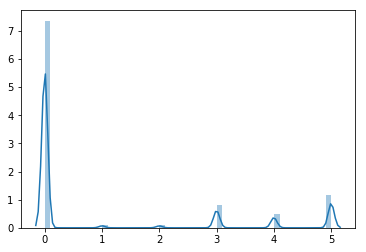

In [11]:
import seaborn as sns
sns.distplot(node_labels_new)

#### Extract Training, Validation and Test Mask

In [12]:
train_mask=train_mask_multi_label
val_mask=val_mask_multi_label
test_mask=test_mask_multi_label

train_idx=torch.nonzero(train_mask.squeeze()).numpy()
val_idx=torch.nonzero(val_mask.squeeze()).numpy()
test_idx=torch.nonzero(test_mask.squeeze()).numpy()

# train_idx=th.from_numpy(train_idx).squeeze(1)    
# val_idx=th.from_numpy(val_idx).squeeze(1)    
# test_idx=th.from_numpy(test_idx).squeeze(1)

label_train=node_labels_new[train_idx].squeeze().numpy()
label_val=node_labels_new[val_idx].squeeze().numpy()
label_test=node_labels_new[test_idx].squeeze().numpy()

df_train=vertices_feat.iloc[train_idx.squeeze(),:]
df_val=vertices_feat.iloc[val_idx.squeeze(),:]
df_test=vertices_feat.iloc[test_idx.squeeze(),:]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,806
validation set  2,566,850 
test set        2,566,848 


In [16]:
%%time
params = {'loss_function':'MultiClass',
         'learning_rate' : 0.01,
         'iterations' : 2000,
         'cat_features' : categorical_index,
         'early_stopping_rounds'  : 200,
         'random_seed' : 101,
         'task_type' : "GPU",
         'verbose' : 200}

model=CatBoostClassifier(**params)
model.fit(df_train, label_train, eval_set=(df_val,label_val),use_best_model=True,early_stopping_rounds=50)

0:	learn: 1.7657464	test: 1.7659254	best: 1.7659254 (0)	total: 633ms	remaining: 21m 5s
200:	learn: 0.3032351	test: 0.3032732	best: 0.3032732 (200)	total: 1m 49s	remaining: 16m 16s
400:	learn: 0.2049475	test: 0.2050130	best: 0.2050130 (400)	total: 3m 40s	remaining: 14m 41s
600:	learn: 0.1893059	test: 0.1894053	best: 0.1894053 (600)	total: 5m 31s	remaining: 12m 51s
800:	learn: 0.1853134	test: 0.1854468	best: 0.1854468 (800)	total: 7m 21s	remaining: 11m 1s
1000:	learn: 0.1832118	test: 0.1833684	best: 0.1833684 (1000)	total: 9m 13s	remaining: 9m 11s
1200:	learn: 0.1819474	test: 0.1821194	best: 0.1821194 (1200)	total: 11m 3s	remaining: 7m 21s
1400:	learn: 0.1810766	test: 0.1812658	best: 0.1812658 (1400)	total: 12m 54s	remaining: 5m 31s
1600:	learn: 0.1804582	test: 0.1806633	best: 0.1806633 (1600)	total: 14m 45s	remaining: 3m 40s
1800:	learn: 0.1799776	test: 0.1801962	best: 0.1801962 (1800)	total: 16m 34s	remaining: 1m 49s
1999:	learn: 0.1796142	test: 0.1798414	best: 0.1798414 (1999)	total: 

In [14]:
# def performance_display(df_train,label_train):
    
#     metrics_dict, preds_proba, roc_auc, pr_auc=predict(df_train,label_train)

#     print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
#     print()
#     print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
#           .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
#                   "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
#                  "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

#     print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
#           .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
#                   "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
#                  "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

#     print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
#           .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
#                   "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
#                  "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

#     print()
#     n_classes=torch.unique(node_labels_new).shape[0]
#     label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

#     report=metrics.classification_report(label_train.squeeze(), preds_proba.argmax(axis=1), output_dict=True)

#     table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
#     table["count"]=table["support"].astype(int)
#     table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
#     table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
#     table["product_type"]=[label_map[i] for i in range(n_classes)]
#     table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]
    
#     table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
#                             metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

#     table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
#                                 metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

#     table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
#                             metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

#     table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})

#### performance in training set

In [17]:
print()
print("********  model performance in training set **********")
print()
    
metrics_dict, preds_proba, roc_auc, pr_auc=predict(df_train,label_train)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=torch.unique(node_labels_new).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(label_train.squeeze(), preds_proba.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                        metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                        metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})


********  model performance in training set **********

accuracy            92.45%    

precision(macro):   71.73%    recall(macro):  53.92%    f1-score(macro):  55.38%    ROC-AUC(macro):  92.82%    PR-AUC(macro):  65.62%    
precision(micro):   92.45%    recall(micro):  92.45%    f1-score(micro):  92.45%    ROC-AUC(micro):  99.66%    PR-AUC(micro):  98.46%    
precision(weight):  92.18%    recall(weight): 92.45%    f1-score(weight): 91.52%    ROC-AUC(weight): 97.59%    PR-AUC(weight): 93.72%    



,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"15,113,075",99.99%,99.78%,99.88%,99.98%,100.00%
1,Rental Only,"191,274",53.49%,13.89%,22.05%,98.97%,41.10%
2,Home Only,"182,783",66.27%,5.91%,10.85%,97.68%,27.51%
3,Auto Only,"1,699,072",65.74%,74.77%,69.96%,97.64%,76.66%
4,Auto + Rental,"990,568",68.70%,32.83%,44.42%,96.63%,58.39%
5,Auto + Home,"2,358,034",76.20%,96.32%,85.09%,98.91%,90.07%
6,MACRO,"20,534,806",71.73%,53.92%,55.38%,92.82%,65.62%
7,MICRO,"20,534,806",92.45%,92.45%,92.45%,99.66%,98.46%
8,WEIGHT,"20,534,806",92.18%,92.45%,91.52%,97.59%,93.72%


#### performance in validation set

In [18]:
print()
print("********  model performance in validation set **********")
print()

metrics_dict, preds_proba, roc_auc, pr_auc=predict(df_val,label_val)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=torch.unique(node_labels_new).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(label_val.squeeze(), preds_proba.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                            metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                            metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})


********  model performance in validation set **********

accuracy            92.43%    

precision(macro):   71.84%    recall(macro):  53.85%    f1-score(macro):  55.31%    ROC-AUC(macro):  92.80%    PR-AUC(macro):  65.52%    
precision(micro):   92.43%    recall(micro):  92.43%    f1-score(micro):  92.43%    ROC-AUC(micro):  99.65%    PR-AUC(micro):  98.46%    
precision(weight):  92.16%    recall(weight): 92.43%    f1-score(weight): 91.50%    ROC-AUC(weight): 97.58%    PR-AUC(weight): 93.71%    



,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"1,889,134",99.99%,99.78%,99.88%,99.99%,100.00%
1,Rental Only,"23,909",53.72%,13.58%,21.67%,98.97%,40.79%
2,Home Only,"22,848",67.07%,6.05%,11.10%,97.66%,27.49%
3,Auto Only,"212,384",65.61%,74.71%,69.87%,97.63%,76.58%
4,Auto + Rental,"123,821",68.43%,32.70%,44.26%,96.62%,58.22%
5,Auto + Home,"294,754",76.21%,96.31%,85.09%,98.91%,90.06%
6,MACRO,"2,566,850",71.84%,53.85%,55.31%,92.80%,65.52%
7,MICRO,"2,566,850",92.43%,92.43%,92.43%,99.65%,98.46%
8,WEIGHT,"2,566,850",92.16%,92.43%,91.50%,97.58%,93.71%


#### performance in test set

In [20]:
print()
print("********  model performance in test set **********")
print()

metrics_dict, preds_proba, roc_auc, pr_auc=predict(df_test,label_test)

print("{:<20}{:<10.2%}".format("accuracy", metrics_dict['acc']))
print()
print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(macro):",metrics_dict['prec_macro'],"recall(macro):",metrics_dict['recall_macro'],\
              "f1-score(macro):",metrics_dict['fscore_macro'],"ROC-AUC(macro):",metrics_dict['auc_macro_ovo'],\
             "PR-AUC(macro):",metrics_dict['pr_auc_macro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(micro):",metrics_dict['prec_micro'],"recall(micro):",metrics_dict['recall_micro'],\
              "f1-score(micro):",metrics_dict['fscore_micro'],"ROC-AUC(micro):",metrics_dict['auc_micro'],\
             "PR-AUC(micro):",metrics_dict['pr_auc_micro']))

print("{:<20}{:<10,.2%}{:<16}{:<10,.2%}{:<18}{:<10,.2%}{:<17}{:<10,.2%}{:<16}{:<10,.2%}"\
      .format("precision(weight):",metrics_dict['prec_weighted'],"recall(weight):",metrics_dict['recall_weighted'],\
              "f1-score(weight):",metrics_dict['fscore_weighted'],"ROC-AUC(weight):",metrics_dict['auc_weighted_ovo'],\
             "PR-AUC(weight):",metrics_dict['pr_auc_weighted']))

print()
n_classes=torch.unique(node_labels_new).shape[0]
label_map={0:"No Product",1:"Rental Only",2:"Home Only",3:"Auto Only",4:"Auto + Rental",5:"Auto + Home"}

report=metrics.classification_report(label_test.squeeze(), preds_proba.argmax(axis=1), output_dict=True)

table = pd.DataFrame(report).transpose().iloc[:n_classes,:]
table["count"]=table["support"].astype(int)
table["roc_auc"]=[roc_auc[i] for i in range(n_classes)]
table["pr_auc"]=[pr_auc[i] for i in range(n_classes)]
table["product_type"]=[label_map[i] for i in range(n_classes)]
table=table[['product_type','count','precision','recall','f1-score','roc_auc','pr_auc']]

total=table['count'].sum()

table.loc[len(table.index)]=["MACRO",total,metrics_dict['prec_macro'],metrics_dict['recall_macro'],metrics_dict['fscore_macro'],\
                            metrics_dict['auc_macro_ovo'],metrics_dict['pr_auc_macro']]

table.loc[len(table.index)]=["MICRO",total,metrics_dict['prec_micro'],metrics_dict['recall_micro'],metrics_dict['fscore_micro'],\
                            metrics_dict['auc_micro'],metrics_dict['pr_auc_micro']]

table.loc[len(table.index)]=["WEIGHT",total,metrics_dict['prec_weighted'],metrics_dict['recall_weighted'],metrics_dict['fscore_weighted'],\
                            metrics_dict['auc_weighted_ovo'],metrics_dict['pr_auc_weighted']]

table.style.format({"count":"{:,}","f1-score":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","roc_auc":"{:.2%}","pr_auc":"{:.2%}"})


********  model performance in test set **********

accuracy            92.43%    

precision(macro):   71.37%    recall(macro):  53.87%    f1-score(macro):  55.31%    ROC-AUC(macro):  92.81%    PR-AUC(macro):  65.54%    
precision(micro):   92.43%    recall(micro):  92.43%    f1-score(micro):  92.43%    ROC-AUC(micro):  99.65%    PR-AUC(micro):  98.46%    
precision(weight):  92.15%    recall(weight): 92.43%    f1-score(weight): 91.50%    ROC-AUC(weight): 97.58%    PR-AUC(weight): 93.71%    



,product_type,count,precision,recall,f1-score,roc_auc,pr_auc
0,No Product,"1,889,134",99.98%,99.78%,99.88%,99.98%,99.99%
1,Rental Only,"23,909",54.25%,14.13%,22.42%,98.97%,41.16%
2,Home Only,"22,847",63.54%,5.61%,10.30%,97.66%,27.18%
3,Auto Only,"212,383",65.67%,74.68%,69.89%,97.63%,76.51%
4,Auto + Rental,"123,821",68.67%,32.75%,44.35%,96.63%,58.34%
5,Auto + Home,"294,754",76.13%,96.27%,85.03%,98.91%,90.06%
6,MACRO,"2,566,848",71.37%,53.87%,55.31%,92.81%,65.54%
7,MICRO,"2,566,848",92.43%,92.43%,92.43%,99.65%,98.46%
8,WEIGHT,"2,566,848",92.15%,92.43%,91.50%,97.58%,93.71%
